In [1]:
import argparse
import json
import os
import time

import pandas as pd
import tensor_parallel as tp
import torch
from tqdm import tqdm
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM

from accelerate import init_empty_weights, load_checkpoint_and_dispatch



#

In [2]:
TASKS = [
        'abstract_algebra',
        'anatomy',
        'astronomy',
        'business_ethics',
        'clinical_knowledge',
        'college_biology',
        'college_chemistry',
        'college_computer_science',
        'college_mathematics',
        'college_medicine',
        'college_physics',
        'computer_security',
        'conceptual_physics',
        'econometrics',
        'electrical_engineering',
        'elementary_mathematics',
        'formal_logic',
        'global_facts',
        'high_school_biology',
        'high_school_chemistry',
        'high_school_computer_science',
        'high_school_european_history',
        'high_school_geography',
        'high_school_government_and_politics',
        'high_school_macroeconomics',
        'high_school_mathematics',
        'high_school_microeconomics',
        'high_school_physics',
        'high_school_psychology',
        'high_school_statistics',
        'high_school_us_history',
        'high_school_world_history',
        'human_aging',
        'human_sexuality',
        'international_law',
        'jurisprudence',
        'logical_fallacies',
        'machine_learning',
        'management',
        'marketing',
        'medical_genetics',
        'miscellaneous',
        'moral_disputes',
        'moral_scenarios',
        'nutrition',
        'philosophy',
        'prehistory',
        'professional_accounting',
        'professional_law',
        'professional_medicine',
        'professional_psychology',
        'public_relations',
        'security_studies', 
        'sociology',
        'us_foreign_policy',
        'virology',
        'world_religions']

choices = ["A", "B", "C", "D"]


In [3]:


def compute_metric(output_filename):
    with open(output_filename, 'r') as f:
        run_results = json.load(f)
    total_acc = 0
    total_num = 0
    for task in run_results:
        acc = 0
        pred_answers = run_results[task]['pred_answers']
        gold_answers = run_results[task]['gold_answers']
        for pred, gold in zip(pred_answers, gold_answers):
            if pred == gold: acc += 1
        print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
        total_acc += acc
        total_num += len(gold_answers)
    print("ACC-all: %.4f" % (total_acc/total_num))


def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

def format_example(df, idx, include_answer=True):
    prompt = df.iloc[idx, 0]
    k = df.shape[1] - 2
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j+1])
    prompt += "\nAnswer:"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(format_subject(subject))
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt


# def custom_stopping_criteria(input_ids, score, **kwargs):
#     stop_ids = [29871, 13, 13] # \n\n 
#     return input_ids[-len(stop_ids)]

def prepare_input(tokenizer, prompts):
    input_tokens = tokenizer.batch_encode_plus(prompts, return_tensors="pt", padding=True)
    input_tokens = {k:input_tokens[k] for k in input_tokens if k in ["input_ids", "attention_mask"]}
    for t in input_tokens:
        if torch.is_tensor(input_tokens[t]):
            input_tokens[t] = input_tokens[t].to('cuda')

    return input_tokens

def load(ckpt_dir, model_type):
    n_gpus = torch.cuda.device_count()

    if model_type == 'llama':
        # we use tensor parallel for loading llama
        tokenizer = LlamaTokenizer.from_pretrained(ckpt_dir, use_fast=False, padding_side="left")
        
        model = LlamaForCausalLM.from_pretrained(ckpt_dir, low_cpu_mem_usage = True, torch_dtype=torch.float16)
        model = tp.tensor_parallel(model, [i for i in range(n_gpus)])

        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
    elif model_type == 'flan':
        # we use tensor parallel for loading llama

        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=False, padding_side="left")
        
        model = AutoModelForSeq2SeqLM.from_pretrained(ckpt_dir, low_cpu_mem_usage = True, torch_dtype=torch.float16)
        model = tp.tensor_parallel(model, [i for i in range(n_gpus)])

        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
    elif model_type == 'falcon':
        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, padding_side="left")
        model = AutoModelForCausalLM.from_pretrained(ckpt_dir, device_map = 'balanced_low_0', torch_dtype=torch.bfloat16, trust_remote_code=True)

        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
    elif model_type == 'moss':
        
        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, padding_side="left")
        config = AutoConfig.from_pretrained(ckpt_dir, trust_remote_code=True)
        with init_empty_weights():
            model = AutoModelForCausalLM.from_config(config, torch_dtype=torch.float16, trust_remote_code=True)
        model.tie_weights()
        model = load_checkpoint_and_dispatch(model, model_path, device_map="auto", no_split_module_classes=["MossBlock"], dtype=torch.float16)
        
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
    elif model_type == 'guanaco':



        model_name = "llama-65b"
        adapters_name = 'guanaco-65b'

        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            load_in_4bit=True,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            max_memory= {i: '24000MB' for i in range(torch.cuda.device_count())},
            quantization_config=BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type='nf4'
            ),
        )
        model = PeftModel.from_pretrained(model, adapters_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)


    elif model_type == 'vicuna':
        
        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, padding_side="left")
        model = AutoModelForCausalLM.from_pretrained(ckpt_dir, device_map = 'balanced_low_0', revision="main", trust_remote_code=False)


        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
        
    elif model_type == 'starcoder':
        
        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, padding_side="left")
        model = AutoModelForCausalLM.from_pretrained(ckpt_dir,device_map = 'balanced_low_0', trust_remote_code=True)
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
        

    else:
        # mpt-30b's tokenizer only has the fast version
        use_fast = "mosaicml/mpt-30b" in ckpt_dir
        # however, tensor parallel for running falcon will occur bugs
        tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, use_fast = use_fast, padding_side="left")
        model = AutoModelForCausalLM.from_pretrained(ckpt_dir, device_map = 'balanced_low_0', torch_dtype=torch.bfloat16, trust_remote_code=True)
        if tokenizer.pad_token_id is None:
            if tokenizer.eos_token_id is not None:
                tokenizer.pad_token_id = tokenizer.eos_token_id
            else:
                tokenizer.pad_token_id = 0


    model.eval()

    return model, tokenizer

def batch_split(prompts, batch_num):
    batch_prompts = []
    mini_batch = []
    for prompt in prompts:
        mini_batch.append(prompt)
        if len(mini_batch) == batch_num:
            batch_prompts.append(mini_batch)
            mini_batch = []
    if len(mini_batch) != 0:
        batch_prompts.append(mini_batch)
    return batch_prompts

def batch_infer_ensemble(models, tokenizers, prompts):


    print('start batch infer')


    
    batch_size = 8
    answers = []
    for batch_input in tqdm(batch_split(prompts, batch_size)):

        model_scores = []
        for model,tokenizer in zip(models,tokenizers):
            encode_inputs = prepare_input(tokenizer, batch_input)
            outputs = model.generate(
                **encode_inputs, 
                max_new_tokens=1, 
                pad_token_id=tokenizer.pad_token_id,
                return_dict_in_generate=True,
                output_scores = True,
            )
            model_scores.append(outputs.scores[0])
        print('start sum scores')
        scores = sum(model_scores)
        print('end sum scores')

        nvm = torch.argmax(scores, axis = 1)

        answers.extend(tokenizer.batch_decode(nvm, skip_special_tokens=True))
        
    answers = [answer[-1] for answer in answers]
    return answers

def batch_infer(model, tokenizer, prompts):

    
    batch_size = 8
    answers = []
    for batch_input in tqdm(batch_split(prompts, batch_size)):

        encode_inputs = prepare_input(tokenizer, batch_input)
        outputs = model.generate(
            **encode_inputs, 
            max_new_tokens=1, 
            pad_token_id=tokenizer.pad_token_id,
            return_dict_in_generate=True,
            output_scores = True,
        )        
        answers.append(outputs.scores[0].to('cpu'))
        
    return answers

def main(ckpt_dir1: str, 
         ckpt_dir2: str, 
         model_type1: str , 
         model_type2 : str, 
         param_size: str, 
         data_dir : str, 
         ntrain : int ):
    
    run_results = {}
    output_filename = 'run_results_%s_%sb.json' % (model_type1+'+'+model_type2, param_size)

    start_time = time.time()

    for ckpt_dir, model_type in zip([ckpt_dir1,ckpt_dir2], [model_type1, model_type2]):
        
        model , tokenizer  =  load(ckpt_dir, model_type)

        for task in TASKS:
            print('Testing %s ...' % task)
            records = []
            dev_df = pd.read_csv(os.path.join(data_dir, "dev", task + "_dev.csv"), header=None)[:ntrain]
            test_df = pd.read_csv(os.path.join(data_dir, "test", task + "_test.csv"), header=None)
            for i in range(test_df.shape[0]):
                # get prompt and make sure it fits
                k = ntrain
                prompt_end = format_example(test_df, i, include_answer=False)
                train_prompt = gen_prompt(dev_df, task, k)
                prompt = train_prompt + prompt_end
                label = test_df.iloc[i, test_df.shape[1]-1]
                
                while any([len(tokenizer.tokenize(prompt)) + 1> 2048 for tokenizer in tokenizers]): # bos token
                    prompt_split = prompt.split("\n\n")
                    popped_answer = prompt_split.pop(1)
                    prompt = '\n\n'.join(prompt_split)
    
                    print('THIS PROMPT DROPPED : '+popped_answer + ": GOLD ANSWER : "+label )
    
                    
                records.append({'prompt':prompt, 'answer':label})
    
            pred_answers = batch_infer(models, tokenizers, [record['prompt'] for record in records])
            gold_answers = [record['answer'] for record in records]
            run_results[task] = {'pred_answers':pred_answers, 'gold_answers':gold_answers}


        model.to('cpu')

        

        

    model1, tokenizer1 = load(ckpt_dir1, model_type1)
    model2, tokenizer2 = load(ckpt_dir2, model_type2)

    models = [model1, model2]
    tokenizers = [tokenizer1, tokenizer2]
    
    with open(output_filename, 'w') as f:
        json.dump(run_results, f, ensure_ascii=False, indent=2)
    
    compute_metric(output_filename)
    end_time = time.time()
    print("total run time %.2f" % (end_time - start_time))
    
    




In [7]:
"""if __name__ == "__main__":
    parser = Object()
    
    parser.add_argument('--ckpt_dir1', type=str, required=True)
    parser.add_argument('--ckpt_dir2', type=str, required=True)
    parser.add_argument('--param_size', type=str, required=True)
    parser.add_argument('--model_type1', type=str, required=True)
    parser.add_argument('--model_type2', type=str, required=True)
    parser.add_argument('--data_dir', type=str, default='data/')
    parser.add_argument('--ntrain', type=int, default=5)
    args = parser.parse_args()
    
    main(args.ckpt_dir1, args.ckpt_dir2, args.param_size, args.model_type)
"""

'if __name__ == "__main__":\n    parser = Object()\n    \n    parser.add_argument(\'--ckpt_dir1\', type=str, required=True)\n    parser.add_argument(\'--ckpt_dir2\', type=str, required=True)\n    parser.add_argument(\'--param_size\', type=str, required=True)\n    parser.add_argument(\'--model_type1\', type=str, required=True)\n    parser.add_argument(\'--model_type2\', type=str, required=True)\n    parser.add_argument(\'--data_dir\', type=str, default=\'data/\')\n    parser.add_argument(\'--ntrain\', type=int, default=5)\n    args = parser.parse_args()\n    \n    main(args.ckpt_dir1, args.ckpt_dir2, args.param_size, args.model_type)\n'

In [4]:
flan_results = torch.load('flanresults.pt')
flantokenizer = AutoTokenizer.from_pretrained('flan-t5-xxl', use_fast=False, padding_side="left")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
llama5b_results = torch.load('llama5bresults.pt')
llamaTokenizer = LlamaTokenizer.from_pretrained('Llama-2-7b-hf', use_fast=False, padding_side="left")


In [11]:
#flan_results
llama5b_results = run_results['llama']

In [7]:
#torch.save(run_results['flan'],'flanresults.pt')
torch.save(run_results['llama'],'llama5bresults.pt')
#run_results

In [ ]:
#ckpt_dir1 = 'falcon-40b'
ckpt_dir1 = 'Llama-2-7b-hf'


param_size = '40 + 35'

#model_type1 = 'falcon'
model_type1 = 'llama'
data_dir = 'data/'
ntrain = 5




run_results = {}
output_filename = 'run_results_%s_%sb.json' % (model_type1, param_size)

start_time = time.time()

for ckpt_dir, model_type in zip([ckpt_dir1], [model_type1]):

    
    
    model , tokenizer  =  load(ckpt_dir, model_type)
    run_results[model_type] = {}

    for task in TASKS:
        print('Testing %s ...' % task)
        records = []
        dev_df = pd.read_csv(os.path.join(data_dir, "dev", task + "_dev.csv"), header=None)[:ntrain]
        test_df = pd.read_csv(os.path.join(data_dir, "test", task + "_test.csv"), header=None)
        for i in range(test_df.shape[0]):
            # get prompt and make sure it fits
            k = ntrain
            prompt_end = format_example(test_df, i, include_answer=False)
            train_prompt = gen_prompt(dev_df, task, k)
            prompt = train_prompt + prompt_end
            label = test_df.iloc[i, test_df.shape[1]-1]
            
            while len(tokenizer.tokenize(prompt)) + 1 > 2048: # bos token
                prompt_split = prompt.split("\n\n")
                popped_answer = prompt_split.pop(1)
                prompt = '\n\n'.join(prompt_split)

                #print('THIS PROMPT DROPPED : '+popped_answer + ": GOLD ANSWER : "+label )

                
            records.append({'prompt':prompt, 'answer':label})

        pred_answers = batch_infer(model, tokenizer, [record['prompt'] for record in records])
        gold_answers = [record['answer'] for record in records]
        run_results[model_type][task] = {'pred_answers':pred_answers, 'gold_answers':gold_answers}


    model.to('cpu')

    

torch.save(run_results['falcon'],'falconresults.pt')




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing abstract_algebra ...


100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Testing anatomy ...


100%|██████████| 17/17 [00:09<00:00,  1.84it/s]


Testing astronomy ...


100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


Testing business_ethics ...


100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Testing clinical_knowledge ...


100%|██████████| 34/34 [00:20<00:00,  1.63it/s]


Testing college_biology ...


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Testing college_chemistry ...


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Testing college_computer_science ...


100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


Testing college_mathematics ...


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


Testing college_medicine ...


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Testing college_physics ...


100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Testing computer_security ...


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Testing conceptual_physics ...


100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Testing econometrics ...


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Testing electrical_engineering ...


100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


Testing elementary_mathematics ...


100%|██████████| 48/48 [00:38<00:00,  1.26it/s]


Testing formal_logic ...


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Testing global_facts ...


100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Testing high_school_biology ...


100%|██████████| 39/39 [00:31<00:00,  1.23it/s]


Testing high_school_chemistry ...


100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


Testing high_school_computer_science ...


100%|██████████| 13/13 [00:18<00:00,  1.42s/it]


Testing high_school_european_history ...


100%|██████████| 21/21 [01:01<00:00,  2.91s/it]


Testing high_school_geography ...


100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


Testing high_school_government_and_politics ...


100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


Testing high_school_macroeconomics ...


100%|██████████| 49/49 [00:29<00:00,  1.68it/s]


Testing high_school_mathematics ...


100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


Testing high_school_microeconomics ...


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


Testing high_school_physics ...


100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Testing high_school_psychology ...


 10%|█         | 7/69 [00:05<00:51,  1.21it/s]

In [18]:
torch.argmax(flan_results['abstract_algebra']['pred_answers'][0], axis = 1)

tensor([205, 272, 205, 272, 272, 272,  71, 272], device='cuda:0')

In [11]:
flan_resultscpu = {subject:[res.to('cpu') for res in results['pred_answers']] for subject, results in flan_results.items()}

In [ ]:
x  = flan_resultscpu['abstract_algebra'][0][:,[71,272,205,309]]+llama5b_results['abstract_algebra']['pred_answers'][0][:,[319,350,316,360]]
torch.argmax(x)

In [62]:
tokens = []
for v in torch.argmax(x,axis = 1):
    if v==0:
        tokens.append('A')
    if v==1:
        tokens.append('B')
    if v==2:
        tokens.append('C')
    if v==3:
        tokens.append('D')
        
tokens


['B', 'B', 'B', 'B', 'B', 'B', 'A', 'B']

In [67]:
flantokenizer

tensor([[25.8281, 25.6094,  9.6406, 25.4219],
        [25.6719, 24.4531,  9.5859, 24.5000],
        [25.3594, 24.9375,  9.9375, 24.7031],
        [24.3906, 24.3906,  9.3906, 23.6875],
        [25.5000, 25.8906,  9.9844, 24.3438],
        [25.6094, 25.3750,  9.8594, 24.9062],
        [25.2031, 24.8281, 10.0938, 24.4531],
        [23.6562, 23.5000,  9.6719, 25.4062]])

In [83]:
flantokenizer.batch_decode(torch.argmax(flan_resultscpu[task][0], axis = 1 ))#[:,[71,272,205,309]]


['D', 'B', 'D', 'D', 'D', 'D', 'A', 'A']

In [87]:
for v in flan_resultscpu[task][0]:
    print(v[[71,272,205,309]])

tensor([-5.3047, -5.4336, -5.4922,  1.4160], dtype=torch.float16)
tensor([-0.3359,  0.4375, -2.9141, -4.3359], dtype=torch.float16)
tensor([-1.6602, -1.9297, -0.4414,  0.0781], dtype=torch.float16)
tensor([-1.3359, -3.8008, -4.8281,  1.2266], dtype=torch.float16)
tensor([-8.6562, -7.2656, -7.4648,  0.7969], dtype=torch.float16)
tensor([ 0.1816, -0.1172, -2.9297,  0.7148], dtype=torch.float16)
tensor([ 0.8301, -4.5117, -0.1250, -3.1758], dtype=torch.float16)
tensor([ 0.7656, -8.3516, -8.5312, -6.5742], dtype=torch.float16)


In [147]:
all_answer_values = {}
for task in llama5b_results:

    all_answer_values_task = []
    for batch in llama5b_results[task]['pred_answers']:
        for answer_val in batch:
            all_answer_values_task.append(answer_val[[319,350,316,360]])

        
    all_answer_values[task] = all_answer_values_task
        
        

    
    
    

In [148]:
analysis_df_llama = []

def gold_to_idx(gold):
    if gold == 'A':
        return 0
    if gold == 'B':
        return 1
    if gold == 'C':
        return 2
    if gold == 'D':
        return 3

for task in flan_resultscpu:
    for answer_val , gold in zip(all_answer_values[task], llama5b_results[task]['gold_answers']):

        ranked_idx = torch.topk( answer_val.to(torch.float32) , 4).indices

        llama5b_results
        
        

        analysis_df_llama.append({
            'model' : 'llama',
            'task' : task,
            'gold' : gold,
            'gold_idx':gold_to_idx(gold),
            'is_correct':gold_to_idx(gold) == torch.argmax(answer_val).item(),
            'top_idx' : torch.argmax(answer_val).item(), 
            'top_val':torch.max(answer_val).item(),
            'gold_val': answer_val[gold_to_idx(gold)].item(),
            'second_idx' : ranked_idx[1].item(),
            'second_val' : answer_val[ranked_idx[1].item()].item(),
            'third_idx' : ranked_idx[2].item(),
            'third_val' : answer_val[ranked_idx[2].item()].item(),
            'fourth_idx' : ranked_idx[3].item(),
            'fourth_val' : answer_val[ranked_idx[3].item()].item(),
            })
analysis_df_llama = pd.DataFrame(analysis_df_llama)
        



In [109]:
analysis_df = []

def gold_to_idx(gold):
    if gold == 'A':
        return 0
    if gold == 'B':
        return 1
    if gold == 'C':
        return 2
    if gold == 'D':
        return 3

for task in flan_resultscpu:
    for answer_val , gold in zip(all_answer_values[task], llama5b_results[task]['gold_answers']):

        ranked_idx = torch.topk( answer_val.to(torch.float32) , 4).indices
        
        

        analysis_df.append({
            'task' : task,
            'gold' : gold,
            'gold_idx':gold_to_idx(gold),
            'is_correct':gold_to_idx(gold) == torch.argmax(answer_val).item(),
            'top_idx' : torch.argmax(answer_val).item(), 
            'top_val':torch.max(answer_val).item(),
            'gold_val': answer_val[gold_to_idx(gold)].item(),
            'second_idx' : ranked_idx[1].item(),
            'second_val' : answer_val[ranked_idx[1].item()].item(),
            'third_idx' : ranked_idx[2].item(),
            'third_val' : answer_val[ranked_idx[2].item()].item(),
            'fourth_idx' : ranked_idx[3].item(),
            'fourth_val' : answer_val[ranked_idx[3].item()].item(),
            })

        



"analysis_df = []\n\ndef gold_to_idx(gold):\n    if gold == 'A':\n        return 0\n    if gold == 'B':\n        return 1\n    if gold == 'C':\n        return 2\n    if gold == 'D':\n        return 3\n\nfor task in flan_resultscpu:\n    for answer_val , gold in zip(all_answer_values[task], llama5b_results[task]['gold_answers']):\n\n        ranked_idx = torch.topk( answer_val.to(torch.float32) , 4).indices\n        \n        \n\n        analysis_df.append({\n            'task' : task,\n            'gold' : gold,\n            'gold_idx':gold_to_idx(gold),\n            'is_correct':gold_to_idx(gold) == torch.argmax(answer_val).item(),\n            'top_idx' : torch.argmax(answer_val).item(), \n            'top_val':torch.max(answer_val).item(),\n            'gold_val': answer_val[gold_to_idx(gold)].item(),\n            'second_idx' : ranked_idx[1].item(),\n            'second_val' : answer_val[ranked_idx[1].item()].item(),\n            'third_idx' : ranked_idx[2].item(),\n            'thi

In [108]:
        

        llama5b_results
        
        

        analysis_df_llama.append({
            'model' : 'llama',
            'task' : task,
            'gold' : gold,
            'gold_idx':gold_to_idx(gold),
            'is_correct':gold_to_idx(gold) == torch.argmax(answer_val).item(),
            'top_idx' : torch.argmax(answer_val).item(), 
            'top_val':torch.max(answer_val).item(),
            'gold_val': answer_val[gold_to_idx(gold)].item(),
            'second_idx' : ranked_idx[1].item(),
            'second_val' : answer_val[ranked_idx[1].item()].item(),
            'third_idx' : ranked_idx[2].item(),
            'third_val' : answer_val[ranked_idx[2].item()].item(),
            'fourth_idx' : ranked_idx[3].item(),
            'fourth_val' : answer_val[ranked_idx[3].item()].item(),
            })
analysis_df_llama = pd.DataFrame(analysis_df_llama)


In [174]:
answer_val2 = flan_resultscpu[task][0][:,[71,272,205,309]]

top_idx2 = torch.topk( answer_val.to(torch.float32) , 4).indices
top_val2 = torch.topk( answer_val.to(torch.float32) , 4).values
top_idx2[:,0]

tensor([3, 1, 3, 3, 3, 3, 0, 0])

no


In [193]:
for answer_val1 , answer_val2 in zip(batch1[:,[319,350,316,360]], batch2[:,[71,272,205,309]]):
    print((answer_val1 , answer_val2))


(tensor([23.4531, 24.7812, 10.4219, 22.0156]), tensor([-4.5039,  0.9727, -2.5293, -5.4297], dtype=torch.float16))
(tensor([24.3594, 25.2188,  9.7344, 23.7500]), tensor([-4.8398,  0.6328, -1.4844, -2.7695], dtype=torch.float16))
(tensor([25.0469, 23.7031,  8.6016, 23.5625]), tensor([-0.0195, -0.7012,  1.6777, -1.0703], dtype=torch.float16))


In [206]:
#flan_resultscpu['abstract_algebra'][0][:,[71,272,205,309]]+llama5b_results['abstract_algebra']['pred_answers'][0][:,[319,350,316,360]]



llama5b_flan_sum_results_overall = {}

flan_weight = 6
for task in llama5b_results.keys():
    results = []
    for batch1, batch2 in zip(llama5b_results[task]['pred_answers'],flan_resultscpu[task]):
        answer_val1 = batch1[:,[319,350,316,360]]
        answer_val2 = batch2[:,[71,272,205,309]]
        tokens = []

        for answer_val1 , answer_val2 in zip(batch1[:,[319,350,316,360]], batch2[:,[71,272,205,309]]):
            top_val1 = torch.topk( answer_val1.to(torch.float32) , 4)
            top_val2 = torch.topk( answer_val2.to(torch.float32) , 4)

            is_confident1 = top_val1.values[0] - top_val1.values[1]  > 2
            is_confident2 = top_val2.values[0] - top_val2.values[1]  > 2

            if is_confident1:
                idx = torch.argmax(answer_val1).item()
            elif is_confident2:
                idx = torch.argmax(answer_val2).item()
            else :
                idx = torch.argmax(answer_val1).item()

            if idx==0:
                tokens.append('A')
            elif idx==1:
                tokens.append('B')
            elif idx==2:
                tokens.append('C')
            elif idx==3:
                tokens.append('D')
            else:
                print('error')
                assert 0

        results.extend(tokens)
    llama5b_flan_sum_results_overall[task] = results

In [49]:
print(torch.argmax(llama5b_results['abstract_algebra']['pred_answers'][1], axis = 1))
llamaTokenizer.batch_decode(torch.argmax(llama5b_results['abstract_algebra']['pred_answers'][1],axis = 1))
# 350 -> "B" , 319 -> "A" , 315 -> "C", 360 -> "D"

tensor([350, 350, 319, 315, 350, 360, 350, 319])


['B', 'B', 'A', 'C', 'B', 'D', 'B', 'A']

In [41]:
llama5b_results_overall = {}
for task in llama5b_results.keys():
    results = []
    for batch in llama5b_results[task]['pred_answers']:
        results.extend(llamaTokenizer.batch_decode(torch.argmax(batch,axis = 1)))
    llama5b_results_overall[task] = results

In [34]:
flan_resultscpu_overall = {}
for task in flan_resultscpu.keys():
    results = []
    for batch in flan_resultscpu[task]:
        results.extend(flantokenizer.batch_decode(torch.argmax(batch,axis = 1)))
    flan_resultscpu_overall[task] = results
    

In [207]:
total_acc = 0

total_num = 0
for task in flan_resultscpu_overall:
    acc = 0
    ensemble_answers = llama5b_flan_sum_results_overall[task]

    gold_answers = llama5b_results[task]['gold_answers']
    for pred, gold in zip(ensemble_answers, gold_answers):
        if (pred == gold):
            acc += 1
    print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
    total_acc += acc

    total_num += len(gold_answers)
print("ACC-all: %.4f" % (total_acc/total_num))


ACC-abstract_algebra: 0.2900
ACC-anatomy: 0.4519
ACC-astronomy: 0.4605
ACC-business_ethics: 0.6800
ACC-clinical_knowledge: 0.5660
ACC-college_biology: 0.4722
ACC-college_chemistry: 0.4000
ACC-college_computer_science: 0.3500
ACC-college_mathematics: 0.3200
ACC-college_medicine: 0.4798
ACC-college_physics: 0.2255
ACC-computer_security: 0.5800
ACC-conceptual_physics: 0.4723
ACC-econometrics: 0.2807
ACC-electrical_engineering: 0.4897
ACC-elementary_mathematics: 0.2804
ACC-formal_logic: 0.3095
ACC-global_facts: 0.3100
ACC-high_school_biology: 0.6323
ACC-high_school_chemistry: 0.3547
ACC-high_school_computer_science: 0.4800
ACC-high_school_european_history: 0.7394
ACC-high_school_geography: 0.6566
ACC-high_school_government_and_politics: 0.7720
ACC-high_school_macroeconomics: 0.5282
ACC-high_school_mathematics: 0.2741
ACC-high_school_microeconomics: 0.5336
ACC-high_school_physics: 0.3179
ACC-high_school_psychology: 0.7560
ACC-high_school_statistics: 0.3657
ACC-high_school_us_history: 0.6569

In [45]:
total_union_acc = 0
total_intersection_acc = 0
total_num = 0
for task in flan_resultscpu_overall:
    union_acc = 0
    intersection_acc = 0
    flan_pred_answers = flan_resultscpu_overall[task]
    llama_pred_answers = llama5b_results_overall[task]
    gold_answers = llama5b_results[task]['gold_answers']
    for flan_pred, llama_pred, gold in zip(flan_pred_answers,llama_pred_answers, gold_answers):
        if (flan_pred == gold) or (llama_pred == gold):
            union_acc += 1

        if (flan_pred == gold) and (llama_pred == gold):
            intersection_acc += 1
    #print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
    total_union_acc += union_acc
    total_intersection_acc += intersection_acc
    total_num += len(gold_answers)
print("ACC-all-union: %.4f" % (total_union_acc/total_num))
print("ACC-all-union: %.4f" % (total_intersection_acc/total_num))


ACC-all-union: 0.6703
ACC-all-union: 0.3334


In [123]:
total_acc = 0

total_num = 0
for task in flan_resultscpu_overall:
    acc = 0
    pred_answers = flan_resultscpu_overall[task]

    gold_answers = llama5b_results[task]['gold_answers']
    for pred, gold in zip(pred_answers, gold_answers):
        if (pred == gold):
            acc += 1
    print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
    total_acc += acc

    total_num += len(gold_answers)
print("ACC-all: %.4f" % (total_acc/total_num))


ACC-abstract_algebra: 0.2200
ACC-anatomy: 0.4741
ACC-astronomy: 0.5855
ACC-business_ethics: 0.6700
ACC-clinical_knowledge: 0.6264
ACC-college_biology: 0.5139
ACC-college_chemistry: 0.3800
ACC-college_computer_science: 0.3500
ACC-college_mathematics: 0.3300
ACC-college_medicine: 0.5202
ACC-college_physics: 0.4118
ACC-computer_security: 0.6400
ACC-conceptual_physics: 0.4468
ACC-econometrics: 0.2368
ACC-electrical_engineering: 0.5862
ACC-elementary_mathematics: 0.3651
ACC-formal_logic: 0.2857
ACC-global_facts: 0.3700
ACC-high_school_biology: 0.6677
ACC-high_school_chemistry: 0.3842
ACC-high_school_computer_science: 0.4900
ACC-high_school_european_history: 0.7879
ACC-high_school_geography: 0.7222
ACC-high_school_government_and_politics: 0.7927
ACC-high_school_macroeconomics: 0.5538
ACC-high_school_mathematics: 0.2630
ACC-high_school_microeconomics: 0.6008
ACC-high_school_physics: 0.2649
ACC-high_school_psychology: 0.7945
ACC-high_school_statistics: 0.3796
ACC-high_school_us_history: 0.7402

In [77]:
total_acc = 0

total_num = 0
for task in flan_resultscpu_overall:
    acc = 0
    pred_answers = llama5b_results_overall[task]

    gold_answers = llama5b_results[task]['gold_answers']
    for pred, gold in zip(pred_answers, gold_answers):
        if (pred == gold):
            acc += 1
    print("ACC-%s: %.4f" % (task, acc/len(gold_answers)))
    total_acc += acc

    total_num += len(gold_answers)
print("ACC-all: %.4f" % (total_acc/total_num))


ACC-abstract_algebra: 0.3000
ACC-anatomy: 0.4741
ACC-astronomy: 0.4079
ACC-business_ethics: 0.5300
ACC-clinical_knowledge: 0.4642
ACC-college_biology: 0.4722
ACC-college_chemistry: 0.3400
ACC-college_computer_science: 0.3300
ACC-college_mathematics: 0.3200
ACC-college_medicine: 0.4277
ACC-college_physics: 0.2157
ACC-computer_security: 0.6000
ACC-conceptual_physics: 0.4213
ACC-econometrics: 0.2807
ACC-electrical_engineering: 0.4828
ACC-elementary_mathematics: 0.2725
ACC-formal_logic: 0.2698
ACC-global_facts: 0.3200
ACC-high_school_biology: 0.5097
ACC-high_school_chemistry: 0.3695
ACC-high_school_computer_science: 0.4000
ACC-high_school_european_history: 0.6182
ACC-high_school_geography: 0.4949
ACC-high_school_government_and_politics: 0.6736
ACC-high_school_macroeconomics: 0.4641
ACC-high_school_mathematics: 0.2926
ACC-high_school_microeconomics: 0.4412
ACC-high_school_physics: 0.3179
ACC-high_school_psychology: 0.6239
ACC-high_school_statistics: 0.2778
ACC-high_school_us_history: 0.5049

In [ ]:
# FLAN '205' -> 'C' , '272' -> 'B' , '71' -> 'A' , '309' -> 'D'
#LLAMA 350 -> "B" , 319 -> "A" , 315 -> "C", 360 -> "D"
# [A,B,C,D]
#FLAN [71,272,205,309]
#LLAMA [319,350,316,360]

In [25]:
flantokenizer.batch_decode(torch.argmax(flan_resultscpu['abstract_algebra'][1], axis = 1), skip_special_tokens=True)

['C', 'D', 'B', 'C', 'C', 'C', 'D', 'B']

In [23]:
flan_results['abstract_algebra']['gold_answers'][0:8]

['B', 'C', 'D', 'B', 'B', 'A', 'A', 'D']

In [17]:
tokenizer.batch_decode(torch.argmax(llama5b_results['abstract_algebra']['pred_answers'][0], axis = 1), skip_special_tokens=True)


['B', 'A', 'C', 'A', 'B', 'A', 'A', 'A']

In [20]:
    
torch.cuda.empty_cache()

with open(output_filename, 'w') as f:
    json.dump(run_results, f, ensure_ascii=False, indent=2)

compute_metric(output_filename)
end_time = time.time()
print("total run time %.2f" % (end_time - start_time))



NameError: name 'tokenizer' is not defined

In [19]:
torch.cuda.empty_cache()


In [12]:
import psutil
psutil.virtual_memory()


svmem(total=1081844498432, available=1012713230336, percent=6.4, used=61227769856, free=5400731648, active=492549255168, inactive=568139595776, buffers=177975296, cached=1015038021632, shared=1578102784, slab=12913483776)

In [160]:
analysis_df['is_correct_int'] = analysis_df.is_correct.astype(int)

In [158]:
analysis_df['is_confident'] = analysis_df['diff_1_2'] > 2

array([[<Axes: title={'center': '(False, flan)'}>,
        <Axes: title={'center': '(False, llama)'}>],
       [<Axes: title={'center': '(True, flan)'}>,
        <Axes: title={'center': '(True, llama)'}>]], dtype=object)

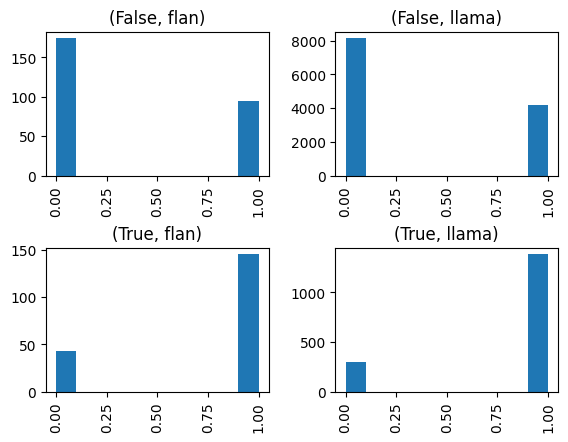

In [161]:
analysis_df.hist('is_correct_int' , by = ['is_confident','model'])


array([[<Axes: title={'center': '(False, flan)'}>,
        <Axes: title={'center': '(False, llama)'}>],
       [<Axes: title={'center': '(True, flan)'}>,
        <Axes: title={'center': '(True, llama)'}>]], dtype=object)

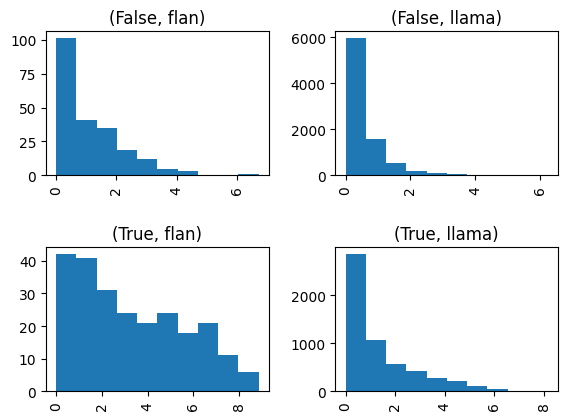

In [157]:
analysis_df.hist('diff_1_2' , by = ['is_correct','model'])


In [150]:
analysis_df_llama

,model,task,gold,gold_idx,is_correct,top_idx,top_val,gold_val,second_idx,second_val,third_idx,third_val,fourth_idx,fourth_val
0,llama,abstract_algebra,B,1,True,1,23.640625,23.640625,0,22.390625,3,22.140625,2,8.976562
1,llama,abstract_algebra,C,2,False,0,23.062500,8.492188,1,22.984375,3,22.109375,2,8.492188
2,llama,abstract_algebra,D,3,False,1,22.187500,21.562500,3,21.562500,0,21.453125,2,8.632812
3,llama,abstract_algebra,B,1,False,0,25.281250,25.171875,1,25.171875,3,24.125000,2,9.445312
4,llama,abstract_algebra,B,1,True,1,22.703125,22.703125,0,22.625000,3,22.375000,2,8.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14037,llama,world_religions,A,0,False,3,24.484375,24.203125,1,24.343750,0,24.203125,2,9.359375
14038,llama,world_religions,C,2,False,3,24.437500,9.187500,1,24.234375,0,23.875000,2,9.187500
14039,llama,world_religions,B,1,True,1,24.781250,24.781250,0,23.453125,3,22.015625,2,10.421875
14040,llama,world_religions,B,1,True,1,25.218750,25.218750,0,24.359375,3,23.750000,2,9.734375


In [ ]:
ACC-human_aging: 0.5605
ACC-human_sexuality: 0.7023
ACC-international_law: 0.7107
ACC-jurisprudence: 0.7037
ACC-logical_fallacies: 0.6380
ACC-machine_learning: 0.3661
ACC-management: 0.7379
ACC-marketing: 0.8590
ACC-medical_genetics: 0.5400
ACC-miscellaneous: 0.7203
ACC-moral_disputes: 0.6445
ACC-moral_scenarios: 0.2804
ACC-nutrition: 0.6176
ACC-philosophy: 0.5627
ACC-prehistory: 0.5802
ACC-professional_accounting: 0.4326
ACC-professional_law: 0.4316
ACC-professional_medicine: 0.5588
ACC-professional_psychology: 0.5376
ACC-public_relations: 0.6091
ACC-security_studies: 0.6939
ACC-sociology: 0.7313
ACC-us_foreign_policy: 0.7700
ACC-virology: 0.4639
ACC-world_religions: 0.7135
ACC-all: 0.5450


ACC-human_aging: 0.6099
ACC-human_sexuality: 0.5878
ACC-international_law: 0.6529
ACC-jurisprudence: 0.6944
ACC-logical_fallacies: 0.6258
ACC-machine_learning: 0.3750
ACC-
': 0.6893
ACC-marketing: 0.7735
ACC-medical_genetics: 0.5500
ACC-miscellaneous: 0.7114
ACC-moral_disputes: 0.5723
ACC-moral_scenarios: 0.2391
ACC-nutrition: 0.5817
ACC-philosophy: 0.5627
ACC-prehistory: 0.5463
ACC-professional_accounting: 0.3759
ACC-professional_law: 0.3937
ACC-professional_medicine: 0.5331
ACC-professional_psychology: 0.4869
ACC-public_relations: 0.5727
ACC-security_studies: 0.6286
ACC-sociology: 0.6965
ACC-us_foreign_policy: 0.7000
ACC-virology: 0.4699
ACC-world_religions: 0.7135
ACC-all: 0.5110

